In [151]:
from diagrams.aws.compute import EC2
from diagrams.aws.database import RDS
from diagrams.aws.network import ELB

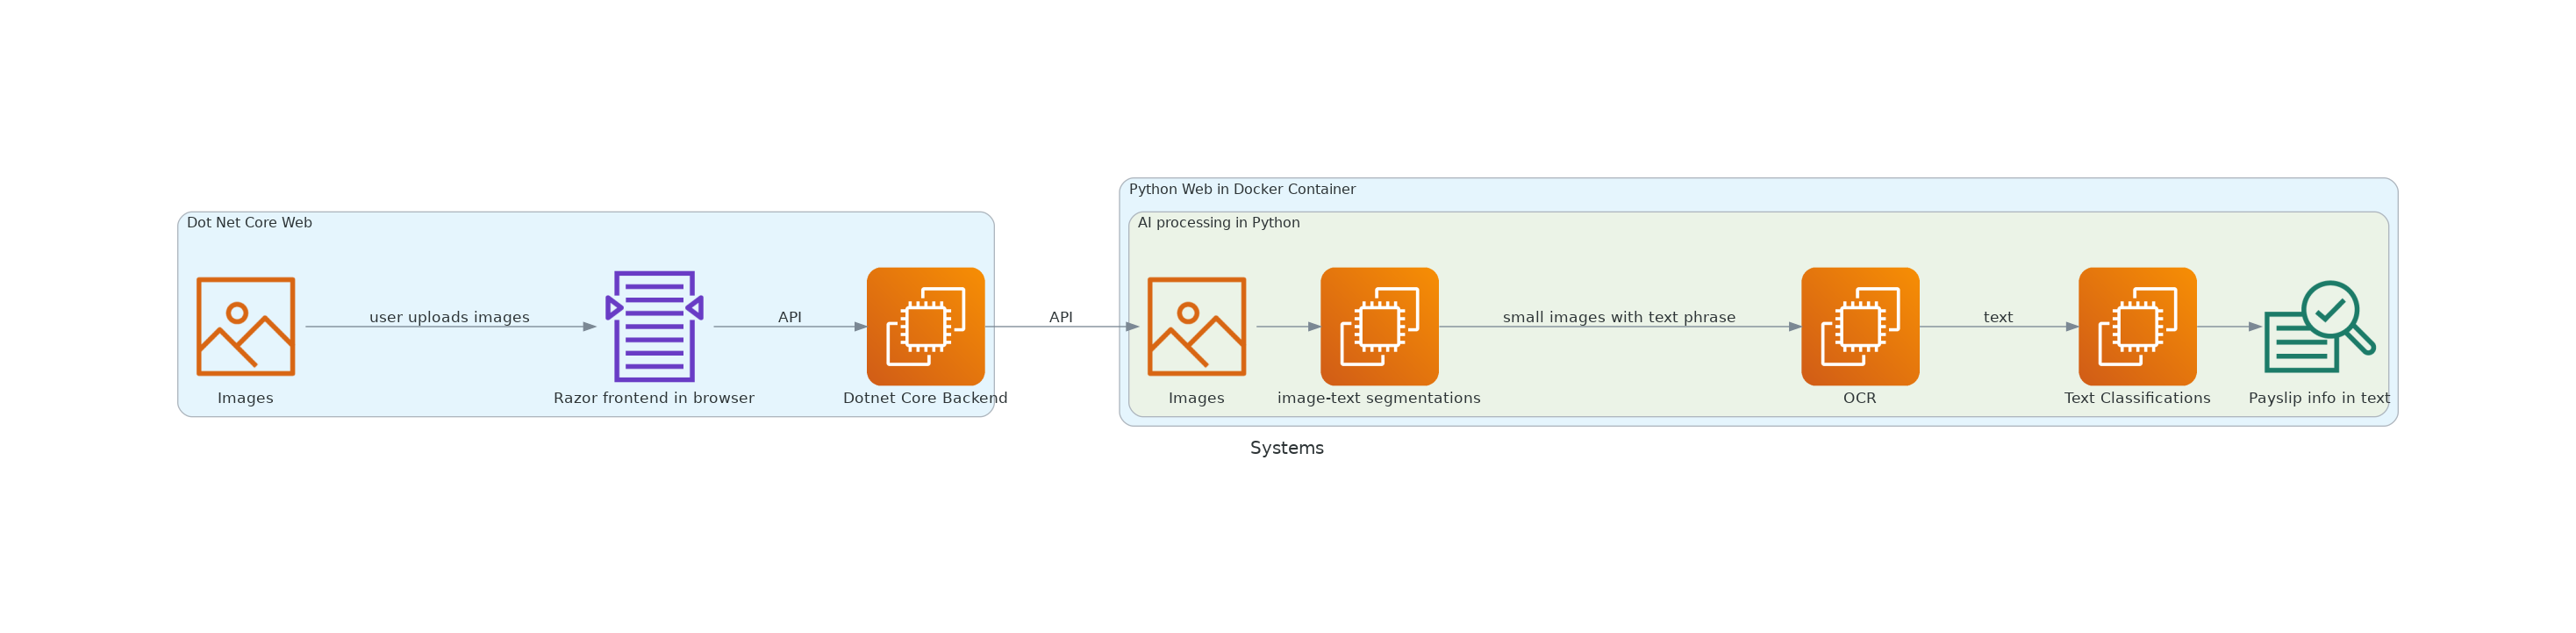

In [152]:
from diagrams import Diagram, Edge, Cluster
from diagrams.aws.compute import EC2
from diagrams.aws.database import RDS
from diagrams.aws.network import ELB
from diagrams.aws.compute import EC2ContainerRegistryImage
from diagrams.aws.ml import SagemakerTrainingJob
from diagrams.aws.analytics import CloudsearchSearchDocuments
with Diagram("Systems", show=False) as fig:
    with Cluster("Dot Net Core Web "):
        rawImg = EC2ContainerRegistryImage("Images")
        frontendSys = CloudsearchSearchDocuments("Razor frontend in browser")
        backendSys = EC2("Dotnet Core Backend")
        dotnetSys = rawImg >> Edge(minlen="2", label="user uploads images") >> frontendSys >>Edge(minlen="2", label="API") >> backendSys
    with Cluster("Python Web in Docker Container"):
        with Cluster("AI processing in Python"):
            i2 = EC2ContainerRegistryImage("Images")
            i2 >>EC2("image-text segmentations")>>  Edge(minlen="2", label="small images with text phrase") \
            >> EC2("OCR") >>  Edge(minlen="2", label="text") >> EC2("Text Classifications") >> SagemakerTrainingJob("Payslip info in text")
        dotnetSys >>Edge(minlen="2", label="API")  >>i2
fig

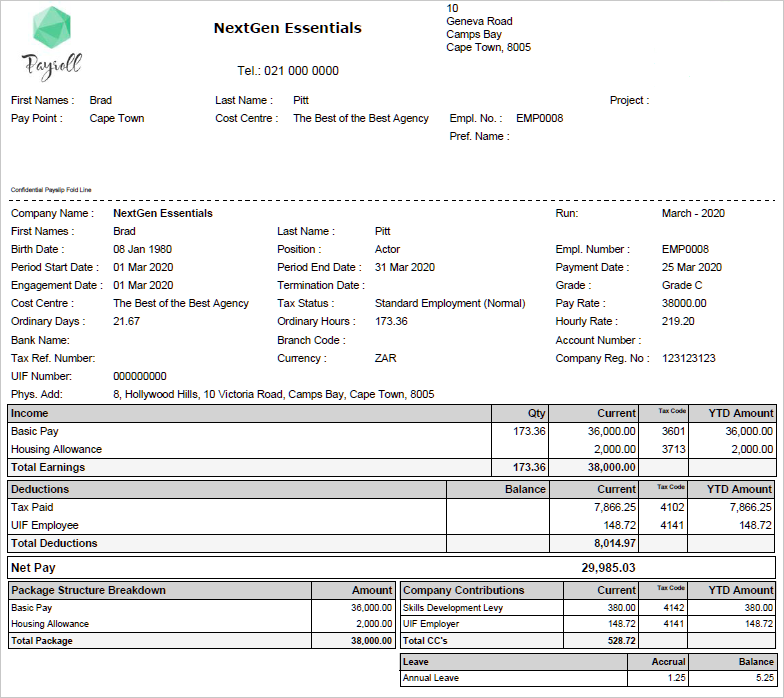

In [153]:
from IPython import display
oriImage = "/home/alextay96/Desktop/all_workspace/personal_workspace/segment_ocr_payslip/data/segment_output/2/0_0_784_698_2.png"
display.Image(oriImage)

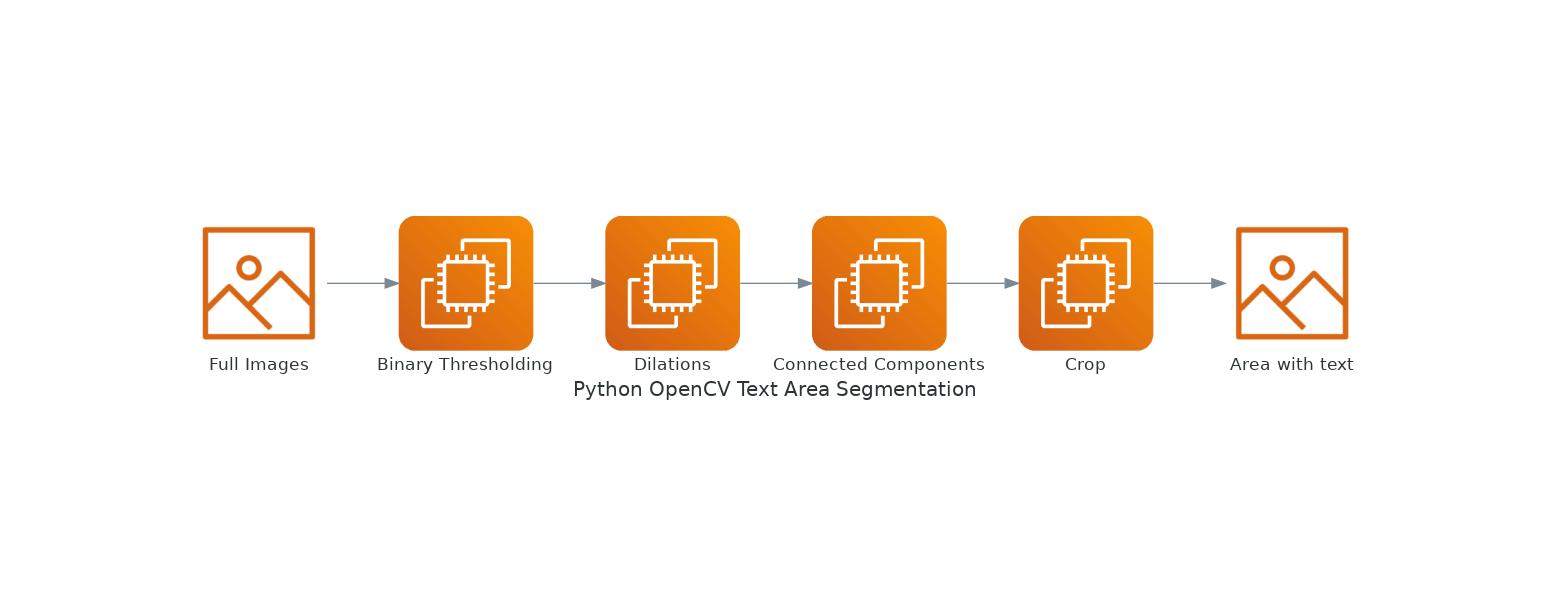

In [186]:
with Diagram("Python OpenCV Text Area Segmentation", show=False) as fig:
    EC2ContainerRegistryImage("Full Images")  >> EC2("Binary Thresholding") >>   EC2("Dilations") >> EC2("Connected Components") \
    >> EC2("Crop") >> EC2ContainerRegistryImage("Area with text")
fig

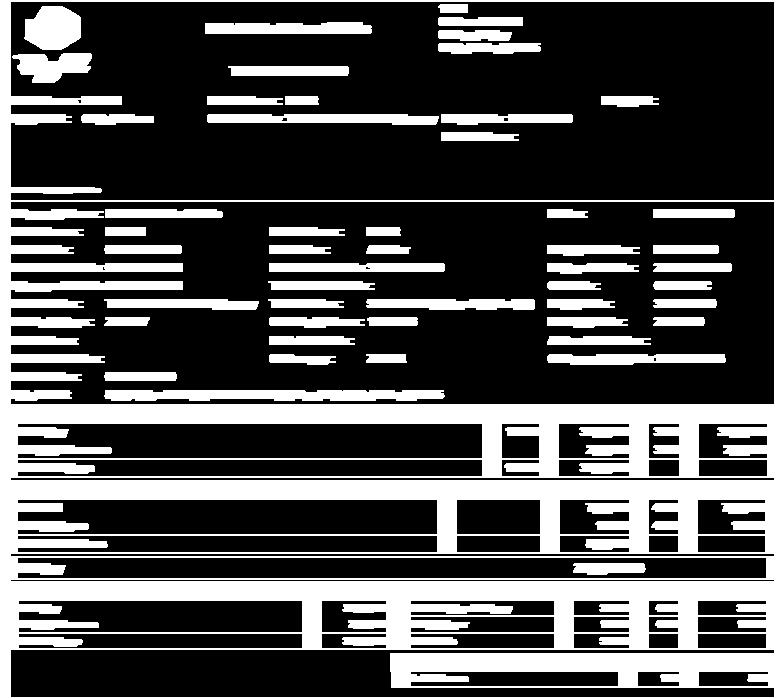

In [171]:
display.Image("/home/alextay96/Desktop/all_workspace/personal_workspace/segment_ocr_payslip/segmentation_mask.png")

In [172]:
display.Image("/home/alextay96/Desktop/all_workspace/personal_workspace/segment_ocr_payslip/data/segment_output/2/228_66_349_76_2.png")

In [173]:
display.Image("/home/alextay96/Desktop/all_workspace/personal_workspace/segment_ocr_payslip/data/segment_output/2/104_390_445_401_2.png")

In [174]:
display.Image("/home/alextay96/Desktop/all_workspace/personal_workspace/segment_ocr_payslip/data/segment_output/2/269_245_331_254_2.png")

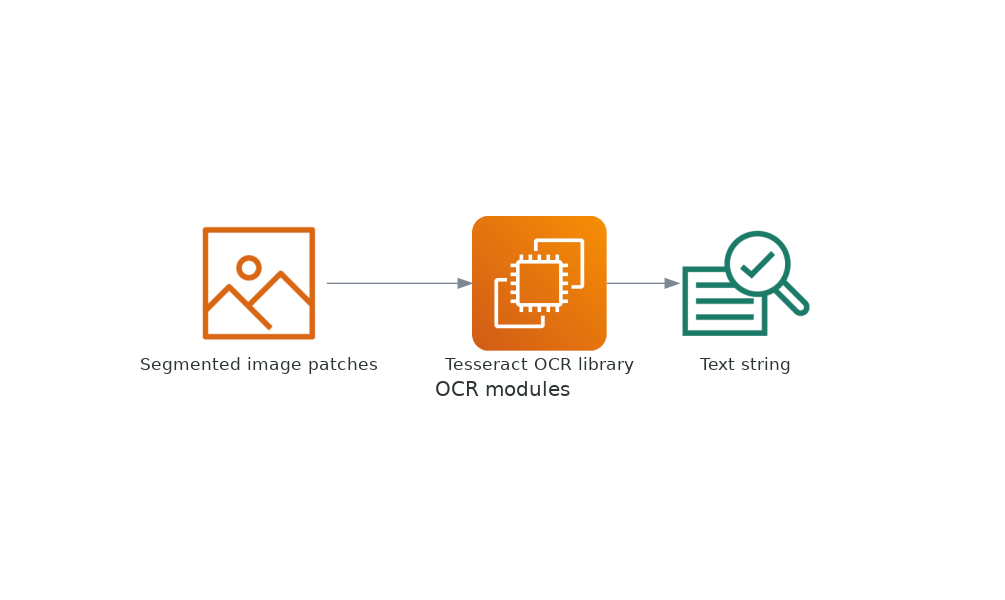

In [175]:
with Diagram("Python Tesseract OCR modules", show=False) as fig:
    EC2ContainerRegistryImage("Segmented image patches")  >>  Edge(minlen="2", label="")  >> EC2("Tesseract OCR library") >>  SagemakerTrainingJob("Text string")
fig

In [176]:
import ujson as json
from collections import OrderedDict
with open("/home/alextay96/Desktop/all_workspace/personal_workspace/segment_ocr_payslip/src/app/cls_name_mapping.json", "r") as f:
    ann = json.load(f)
ann

{'3': 'IC_key',
 '10': 'IC_value',
 '1': 'companyName_key',
 '0': 'companyName_value',
 '2': 'employeeName_key',
 '4': 'employeeName_value',
 '7': 'netPay_key',
 '8': 'netPay_value',
 '5': 'payDate_key',
 '6': 'payDate_value',
 '9': 'reject'}

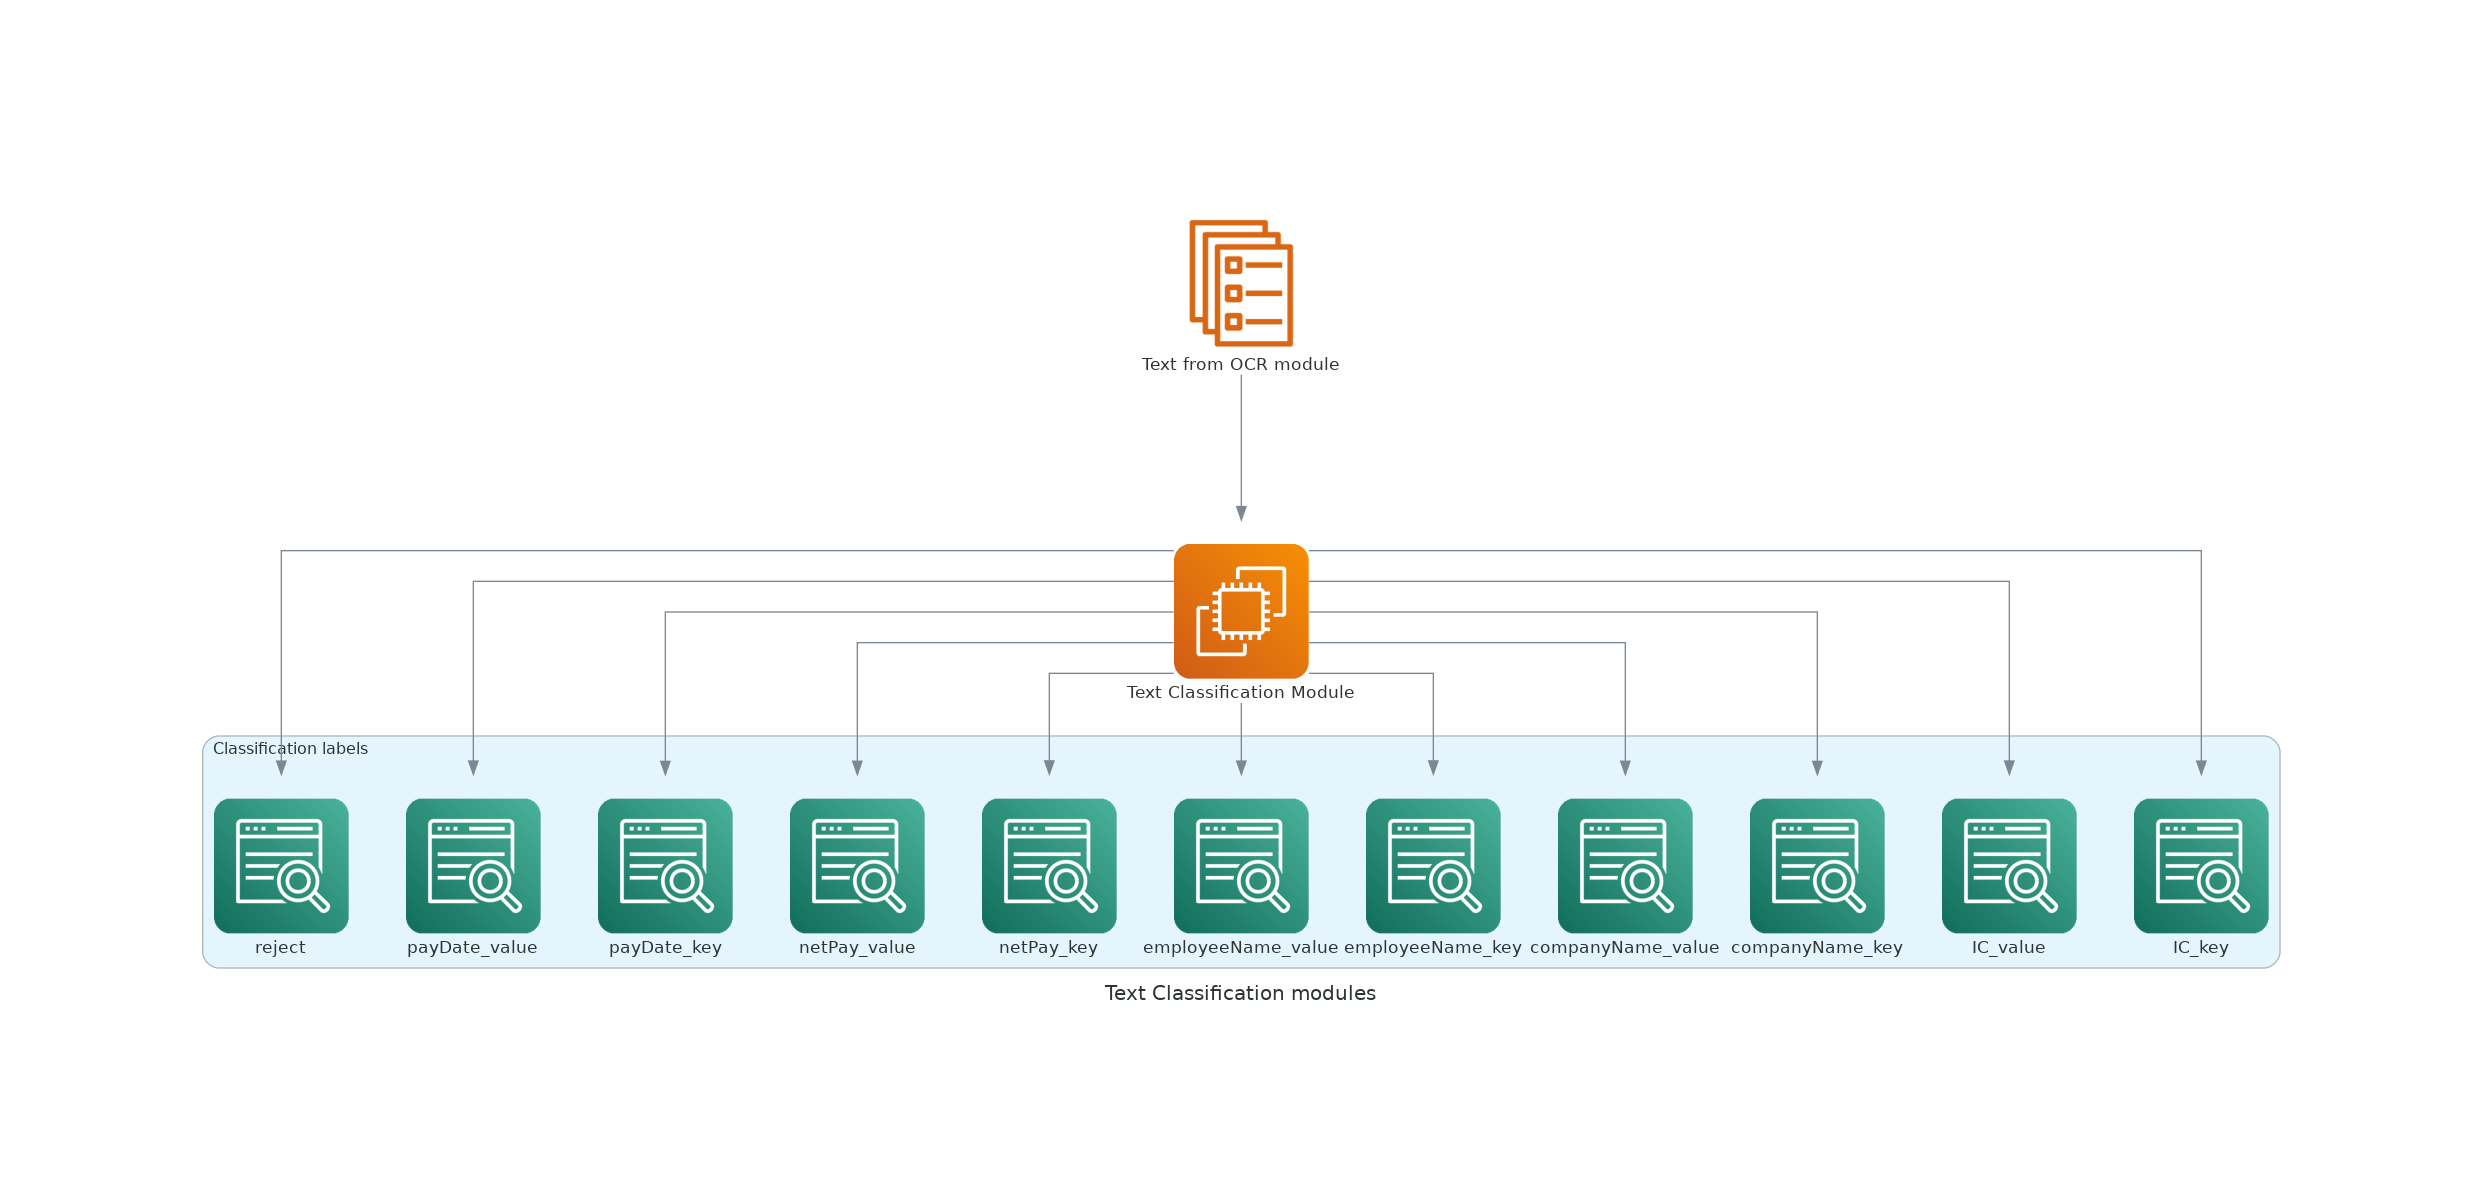

In [177]:
from diagrams.aws.ml import Kendra
from diagrams.aws.compute import ElasticContainerServiceService
with Diagram("Text Classification modules", direction="TB",show=False) as fig:
    with Cluster("Classification labels"):
        allLabel = []
        for k, v in ann.items():
            allLabel.append(Kendra(v))
    
    ElasticContainerServiceService("Text from OCR module")  >>  \
    Edge(minlen="2", label="") >> EC2("Text Classification Module") >> allLabel

fig

79.74588871002197
20.254111289978027


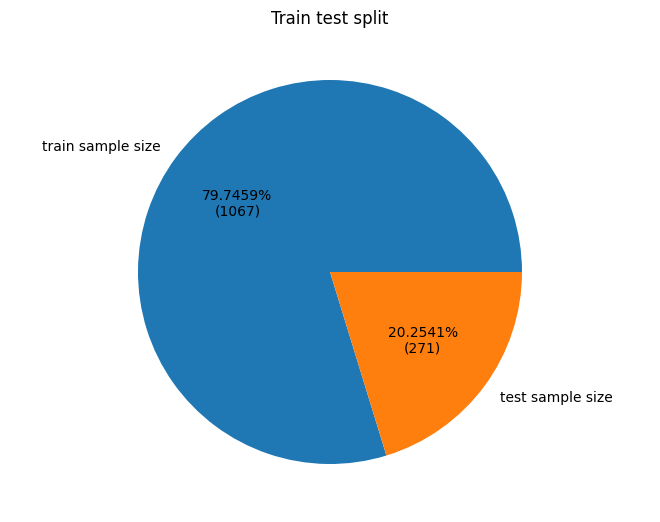

In [178]:
from matplotlib import pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ["train sample size", "test sample size"]
students = [1067,
271]
total = 1338
def my_fmt(x):
    print(x)
    return '{:.4f}%\n({:.0f})'.format(x, total*x/100)
ax.pie(students, labels = langs, autopct=my_fmt)
plt.title("Train test split")
plt.show()

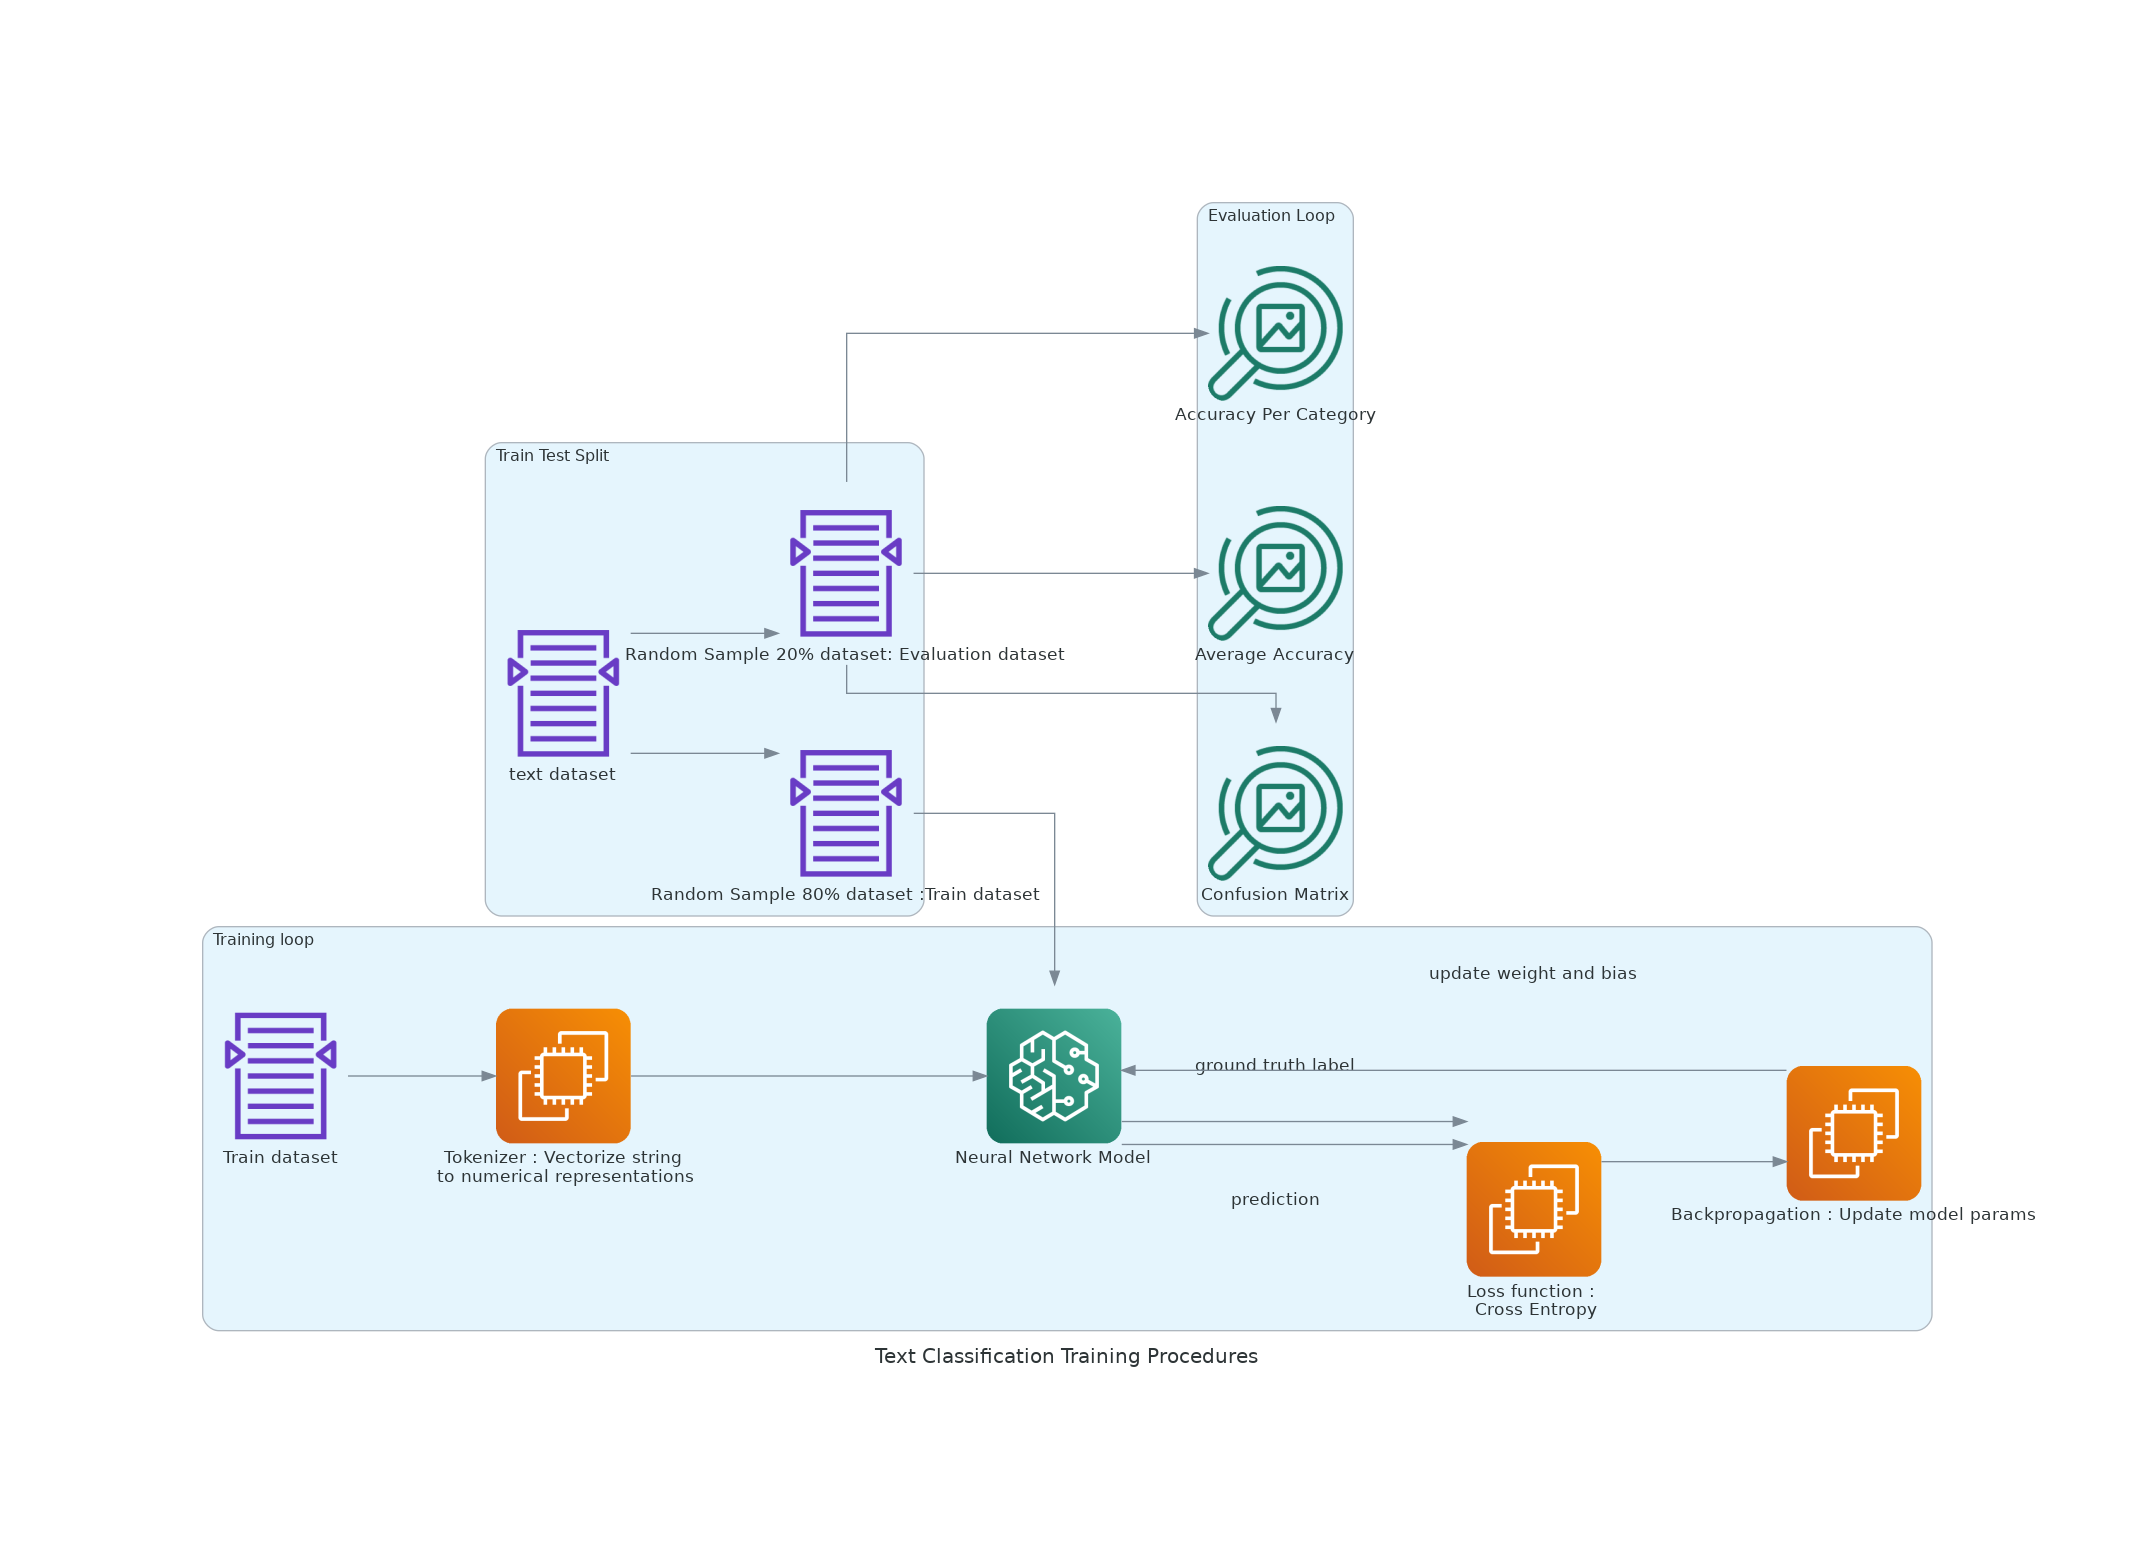

In [179]:
from diagrams.aws.ml import Sagemaker, RekognitionImage
with Diagram("Text Classification Training Procedures", direction="LR",show=False) as fig:
    with Cluster("Train Test Split") :
        dataset = CloudsearchSearchDocuments("text dataset")
        trainDs = CloudsearchSearchDocuments("Random Sample 80% dataset :Train dataset")
        testDs = CloudsearchSearchDocuments("Random Sample 20% dataset: Evaluation dataset")
        dataset >>  Edge(minlen="2") >> [trainDs , testDs]
    with Cluster("Training loop") :
        rawString = CloudsearchSearchDocuments("Train dataset")
        tokenizer = EC2("Tokenizer : Vectorize string\n to numerical representations")
        model = Sagemaker("Neural Network Model")
        lossFunction = EC2("Loss function : \n Cross Entropy")
        backProp = EC2("Backpropagation : Update model params")
        rawString >>Edge(minlen="2") >> tokenizer >> Edge(minlen="3") >>  model 

        trainDs >> model >>Edge(minlen="2", label="prediction") >> lossFunction
        model >> Edge(minlen="2", label="ground truth label") >> lossFunction
        lossFunction >> Edge(minlen="2")>> backProp >> Edge(minlen="2", label="update weight and bias")>> model
    with Cluster("Evaluation Loop") :
        testDs >> Edge(minlen="2")>> [RekognitionImage("Confusion Matrix"), RekognitionImage("Accuracy Per Category") ,RekognitionImage("Average Accuracy")]

fig

In [180]:
import pandas as pd

In [181]:
metricsJsonFile = "/home/alextay96/Desktop/all_workspace/personal_workspace/segment_ocr_payslip/all_metrics.json"
with open(metricsJsonFile, "r") as f:
    metrics = json.load(f)
allMetricsByPart = []
for k, v in metrics.items():
    if(isinstance(v, dict) and "avg" not in k):
        allMetricsByPart.append({
            "category" : k,
            "accuracy" : v["accuracy"] / v["support"],
            "samples" : v["support"]
        })
accWithData = pd.json_normalize(allMetricsByPart)
avgTestAcc = metrics["accuracy"]
avgTrainAcc =  metrics["train_avg_acc"]
avgTrainLoss =  metrics["train_loss"]

In [182]:
import seaborn as sns
import plotly.express as px
fig = px.bar(accWithData, x="category", y="accuracy", text_auto=True)
fig.add_hline(y=avgTestAcc, line_width=2, line_color="red")
fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTestAcc, 2)],
    )
)

In [183]:
AvgDf = pd.json_normalize([
   {
   "metric" : "train_accuracy",
   "value" : avgTrainAcc
   },
   {
   "metric" : "test_accuracy",
   "value" : avgTestAcc
   },
   {
   "metric" : "train_loss",
   "value" : avgTrainLoss
   },
]

)
fig = px.bar(AvgDf, x="metric", y="value", text_auto=True)
fig

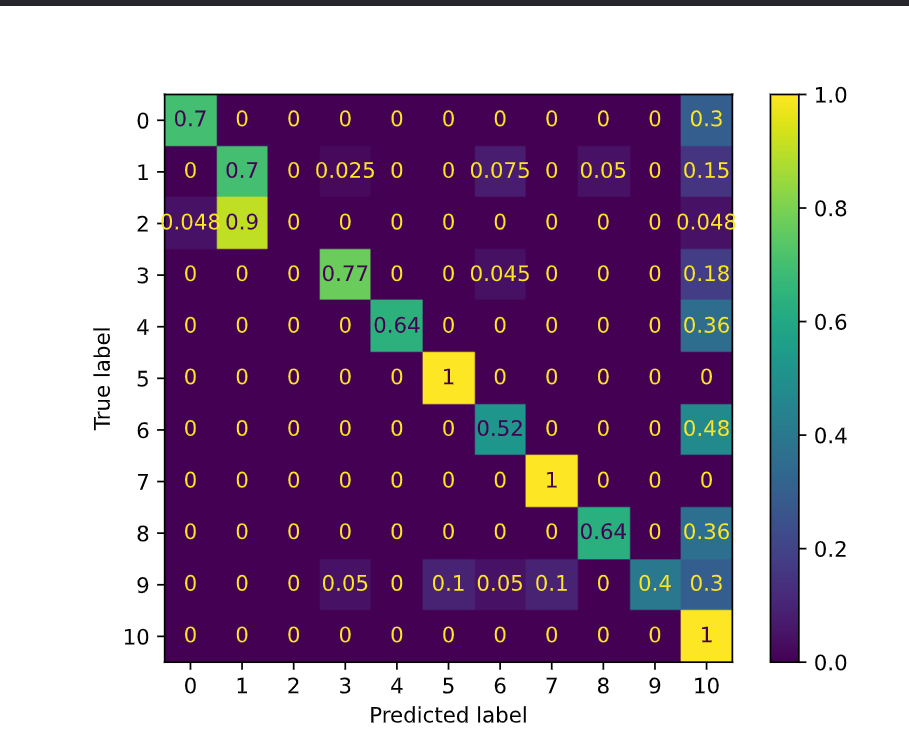

In [184]:
display.Image("/home/alextay96/Desktop/all_workspace/personal_workspace/segment_ocr_payslip/confusion_matrix.png")

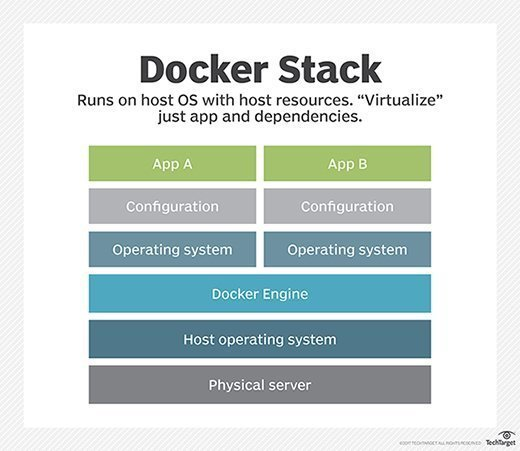

In [185]:
display.Image("/home/alextay96/Desktop/all_workspace/personal_workspace/segment_ocr_payslip/itops-docker_stack_mobile.jpg")